## ECG Heartbeat Classification (MIT-BIH arrhythmia)

Note: The data [MIT-BIH arrhythmia data](https://www.physionet.org/physiobank/database/mitdb/) is taken from [kaggle](https://www.kaggle.com/shayanfazeli/heartbeat).

A deep learning model based on temporal convolutional layers for the heartbeat classification was proposed in 

```
Kachuee, Mohammad, Shayan Fazeli, and Majid Sarrafzadeh. 
"ECG Heartbeat Classification: A Deep Transferable Representation." arXiv preprint arXiv:1805.00794 (2018).
```

Lets see how well we can do without introducing deep structures and learnable convolution parameters into a classifier. Without convolving the signals directly in the model, the signal preprocessing will have a significant impact on the performance of our models. 

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We start off by loading the data and separating the target column from the training features.

In [20]:
trainpath = "../data/mitbih_train.csv"
x_train = pd.read_csv(trainpath,header=None,usecols=range(187))
y_train = pd.read_csv(trainpath,header=None,usecols=[187]).iloc[:,0]

In [21]:
testpath = "../data/mitbih_test.csv"
x_test = pd.read_csv(testpath,header=None,usecols=range(187))
y_test = pd.read_csv(testpath,header=None,usecols=[187]).iloc[:,0]

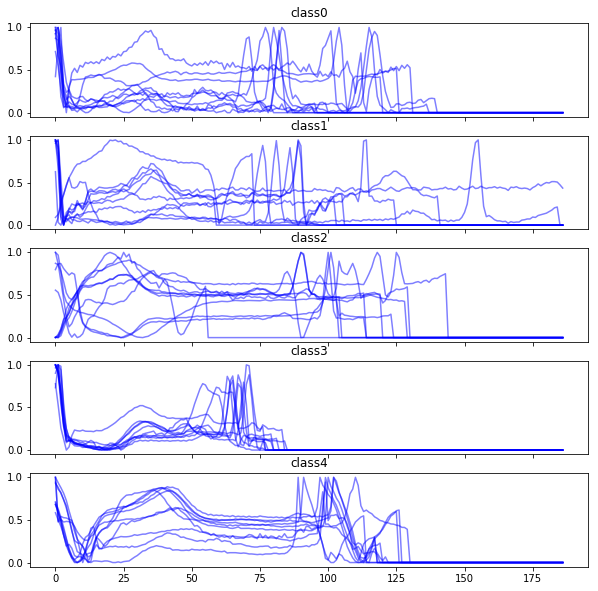

In [23]:
def plot(x_data, y_data, classes=range(5), plots_per_class=10):

    f, ax = plt.subplots(5, sharex=True, sharey=True, figsize=(10,10))
    for i in classes:
        for j in range(plots_per_class):
            ax[i].set_title("class{}".format(i))
            ax[i].plot(x_data[y_data == i].iloc[j,:], color="blue", alpha=.5)
            
plot(x_train, y_train)

Lets have a look at the data. We have $\sim 80k$ samples of one-beat ECG cycles. Each sample is a $[0,1]$ interval normalized timeseries padded with zeros at the end to fit a unified timeframe.

Lets try to understand our target variable. We have a $5$-class with a heavily oversampled "0"-class. This means, that we have to account for the underrepresented classes with a weight in the loss function later on. Else, the model might classify everything a "0" and still perform well, but this is obviously not what we want.
The class encoding has the following meaning:

| class |heart condition |
|---|---|
| 0  |  Normal, Left/Right bundle branch block, Atrial escape, Nodal escape|   
| 1  | Atrial premature, Aberrant atrial premature, Nodal premature, Supra-ventricular premature  | 
| 2  | Premature ventricular contraction, Ventricular escape  |  
| 3  | Fusion of ventricular and norma  |  
| 4  | Paced, Fusion of paced and normal, Unclassifiable  |  

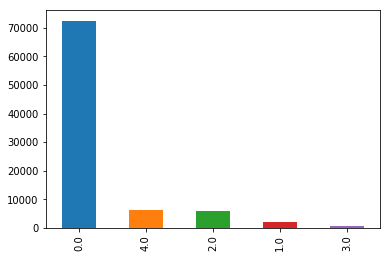

In [24]:
y_train.value_counts().plot(kind="bar")

### Preprocessing

Since we already have a lot of padded zeros in our data, it is only fair to make use of sparse matrices in the end by setting a threshold for our signal. Furthermore, we can add additional information by taking the magnitude of the dicrete signal gradients into account.

We can also try to add manual convolution, for example with a discrete gaussian. Similarly, we can incorporate manual max pooling by using the```pd.DataFrame.rolling``` function.

Additionally, we downsample our signal by using ```scipy.signal.decimate```-

In [25]:
from scipy.signal import gaussian, decimate
from scipy.sparse import csr_matrix

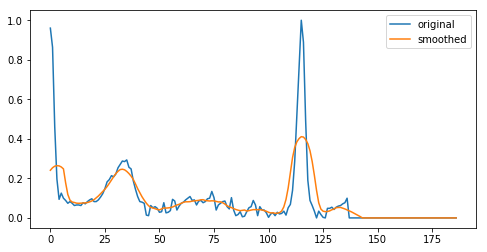

In [26]:
def gaussian_smoothing(data, window, std):
    gauss = gaussian(window ,std, sym=True)
    x = np.convolve(gauss/gauss.sum(), data, mode='same')
    return x   

fig = plt.figure(figsize=(8,4))
plt.plot(x_train.iloc[1,:], label="original")
plt.plot(gaussian_smoothing(x_train.iloc[1,:],12,7), label="smoothed")
plt.legend()

In [27]:
def gradient(data):
    return data.diff(axis=1, periods=2)

def preprocess(data):
    
    data = data.abs().rolling(5, axis=1).max()
    data = data.fillna(method="bfill",axis=1)
    data = decimate(data, axis=1, q=4)
    data[np.abs(data) < .05] = 0
    return pd.DataFrame(data)

x_train_preprocessed = preprocess(pd.concat([x_train,gradient(x_train)], axis=1))
x_test_preprocessed = preprocess(pd.concat([x_test,gradient(x_test)], axis=1))

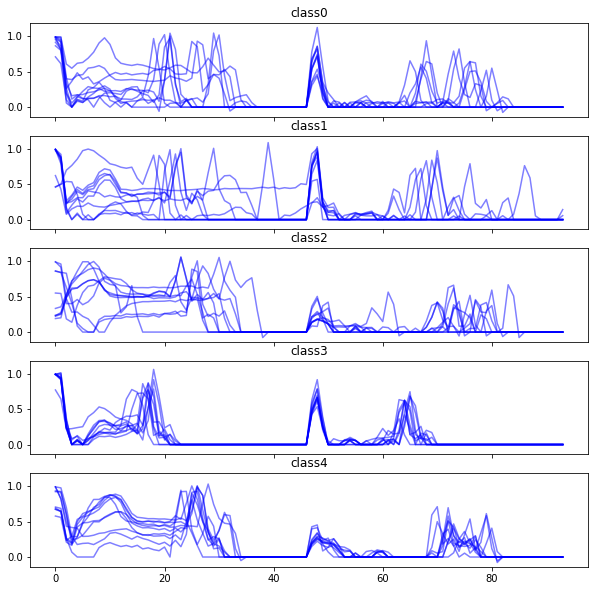

In [28]:
plot(x_train_preprocessed, y_train)
x_preprocessed = csr_matrix(x_train_preprocessed)

### Fitting a Scikit-lean benchmark model

For a first intuition, we fit a logistic regression with a one-versus-rest approach for multilabel classification. We use the standard Newton conjugate gradient solver and add class weights according to the number of samples in the data to the loss function.

We regularize the loss with standard $L2$ penalty.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [30]:
model = LogisticRegression(multi_class="ovr",solver="newton-cg", class_weight="balanced",
                          n_jobs=2, max_iter=100, C=.5)

In [31]:
model.fit(x_train_preprocessed,y_train)

LogisticRegression(C=0.5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=2, penalty='l2', random_state=None,
          solver='newton-cg', tol=0.0001, verbose=0, warm_start=False)

In [32]:
y_predict = model.predict(x_test_preprocessed)
cf = confusion_matrix(y_test,y_predict)
print("accuracy: " + str(accuracy_score(y_test,y_predict)))

accuracy: 0.8599031609720446


In [33]:
cf_relative = cf / cf.sum(axis=1)[:,None]

In [34]:
cf

array([[15679,   738,   720,   677,   304],
       [  166,   347,    25,    14,     4],
       [  115,    59,  1179,    61,    34],
       [   20,     0,    17,   125,     0],
       [   55,     3,    48,     7,  1495]])

In [35]:
cf_relative.round(decimals=2)

array([[0.87, 0.04, 0.04, 0.04, 0.02],
       [0.3 , 0.62, 0.04, 0.03, 0.01],
       [0.08, 0.04, 0.81, 0.04, 0.02],
       [0.12, 0.  , 0.1 , 0.77, 0.  ],
       [0.03, 0.  , 0.03, 0.  , 0.93]])

In [36]:
print(classification_report(y_test, y_predict))

             precision    recall  f1-score   support

        0.0       0.98      0.87      0.92     18118
        1.0       0.30      0.62      0.41       556
        2.0       0.59      0.81      0.69      1448
        3.0       0.14      0.77      0.24       162
        4.0       0.81      0.93      0.87      1608

avg / total       0.92      0.86      0.88     21892



By the nature of our problem, we are obviously interested in high recall values for each class from "1" to "4". It is significantly worse to label a person with a relevant heart condition ("1"-"4") as normal ("0") than to label a person with a normal heart ("0") as one of the latter classes ("1"-"4").

We see that our benchmark model performs quite well for the class "4", we however misclassify a significant amount of patients in the "1" and "2" class as "0".

# TensorFlow softmax regression

Still to come...